# Customer Segmentation
Grouping and Clustering each transaction as Customer Segments.
This was achieved with two methods:
- KMeans Elbow method and Principal Component Analysis (PCA)
- Grouping customers based on Store Size vs Avg Weekly Sales

In [96]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")  # or sns.set_style("whitegrid")

In [98]:
# Cell 2: Load Cleaned Dataset
df_cleaned = pd.read_csv("../data/processed/cleaned.csv")
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Optional: Check data
df_cleaned.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y
0,0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,False
1,1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,211.242170,8.106,True
2,2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,211.289143,8.106,False
3,3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,211.319643,8.106,False
4,4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,211.350143,8.106,False


In [99]:
# Cell 3: Aggregate Data by Store
store_data = df_cleaned.groupby('Store').agg({
    'Weekly_Sales': ['sum', 'mean'],
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'Size': 'mean'
})

store_data.columns = ['_'.join(col) for col in store_data.columns]
store_data.reset_index(inplace=True)

store_data.head()

,Store,Weekly_Sales_sum,Weekly_Sales_mean,Temperature_mean,Fuel_Price_mean,CPI_mean,Unemployment_mean,Size_mean
0,1,2.224028e+08,21710.543621,68.224463,3.218811,215.995525,7.610918,151315.0
1,2,2.753824e+08,26898.070031,68.105435,3.219898,215.651869,7.623279,202307.0
2,3,5.758674e+07,6373.033983,71.298627,3.219112,219.402843,7.175602,37392.0
3,4,2.995440e+08,29161.210415,62.176867,3.216237,128.680070,5.965849,205863.0
4,5,4.547569e+07,5053.415813,69.203619,3.220912,216.576516,6.296549,34875.0


In [102]:
# Cell 4: Normalize Features
features = store_data.drop(columns=['Store'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

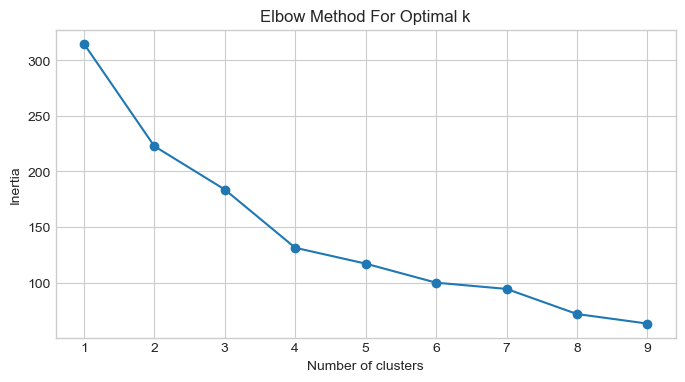

In [104]:
# Cell 5: Elbow Method to Find Optimal Clusters
inertia = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(K)
plt.grid(True)
plt.show()

By seeing the above graph, we use the elbow method to find the optimal number of clusters (here which is 4)

In [107]:
# Cell 6: Fit KMeans with Optimal Clusters (e.g., 3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
store_data['Cluster'] = kmeans.fit_predict(X_scaled)


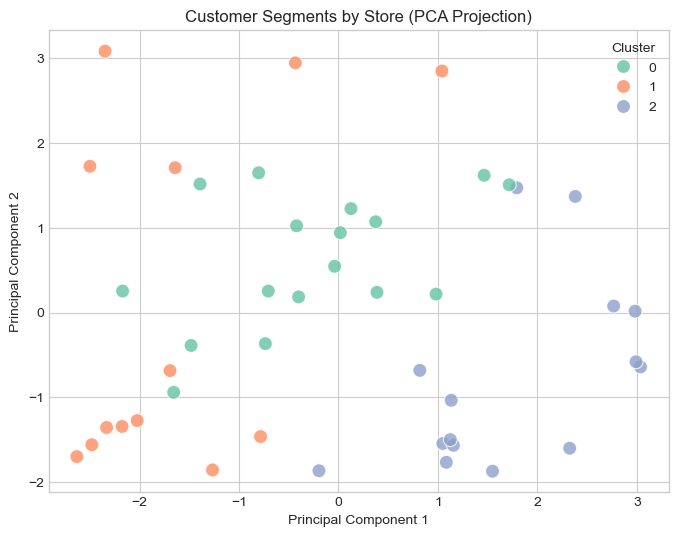

In [109]:
# Cell 7: Visualize Clusters with PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
store_data['PC1'] = principal_components[:, 0]
store_data['PC2'] = principal_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=store_data,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set2',
    s=100,
    alpha=0.8
)
plt.title('Customer Segments by Store (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

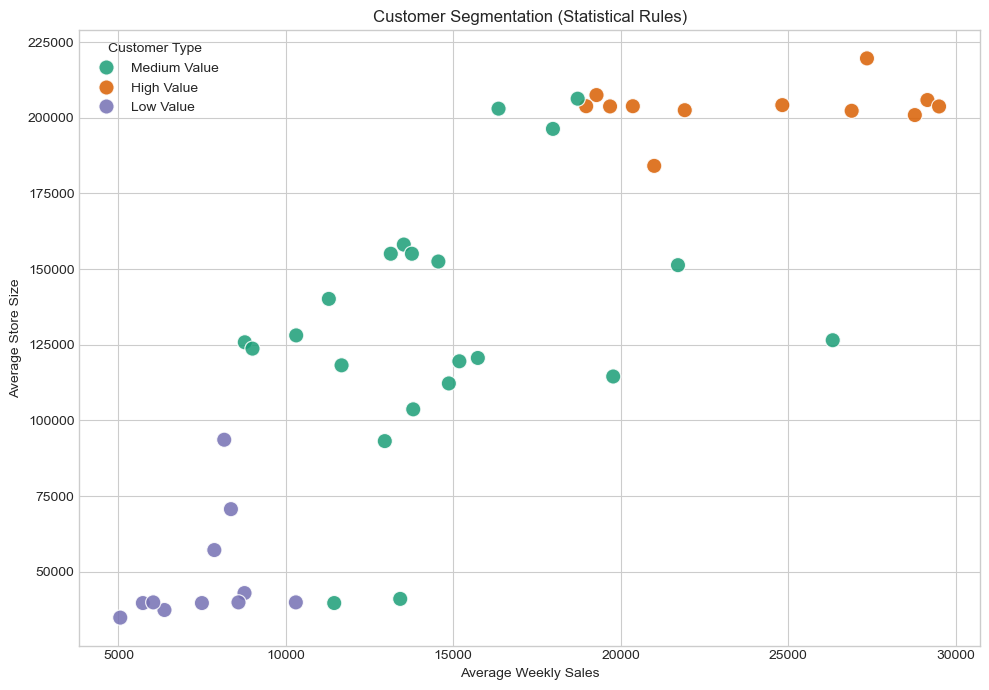

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Drop any previous cluster if present
store_data = store_data.drop(columns=['Cluster'], errors='ignore')

# Define customer types using quantiles on Weekly_Sales_mean and Size_mean
conditions = [
    (store_data['Weekly_Sales_mean'] > store_data['Weekly_Sales_mean'].quantile(0.66)) & 
    (store_data['Size_mean'] > store_data['Size_mean'].quantile(0.66)),

    (store_data['Weekly_Sales_mean'] < store_data['Weekly_Sales_mean'].quantile(0.33)) & 
    (store_data['Size_mean'] < store_data['Size_mean'].quantile(0.33))
]

choices = ['High Value', 'Low Value']
store_data['Customer_Type'] = 'Medium Value'  # Default
store_data.loc[conditions[0], 'Customer_Type'] = 'High Value'
store_data.loc[conditions[1], 'Customer_Type'] = 'Low Value'

# Scatterplot without PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=store_data,
    x='Weekly_Sales_mean',
    y='Size_mean',
    hue='Customer_Type',
    palette='Dark2',
    s=120,
    alpha=0.85
)
plt.title('Customer Segmentation (Statistical Rules)')
plt.xlabel('Average Weekly Sales')
plt.ylabel('Average Store Size')
plt.grid(True)
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()

In [113]:
# Cell 9: Export Clustered Store Data
output_path = "../data/processed/clustered_store_data.csv"
store_data.to_csv(output_path, index=False)

print(f"Clustered store data exported to: {output_path}")

Clustered store data exported to: ../data/processed/clustered_store_data.csv
